In [31]:
import re
import os
import time
import h5py
import string
import pickle
import datetime
import javalang
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfh
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from dpu_utils.mlutils import Vocabulary
from gensim.models import KeyedVectors as word2vec
from sklearn.model_selection import train_test_split

import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [32]:
MODEL_TYPE = 'att'

# Data acquisition

In [33]:
LANGUAGE = "java" #"python"
DATA_PATH = "../../Data/code2desc"
DATA_FOLDER = f"{LANGUAGE}/short"
TRAIN_FILE  = f"{LANGUAGE}_train_0.jsonl"
TEST_FILE   = f"{LANGUAGE}_test_0.jsonl"
VALID_FILE  = f"{LANGUAGE}_valid_0.jsonl"

use_cols = ["code", "docstring"] # code_tokens

In [34]:
def read_data(scope, n_splits):
    def get_file(scope, split_ind):
        return pd.read_json(f"{DATA_PATH}/{DATA_FOLDER}/{LANGUAGE}_{scope}_{split_ind}.jsonl", lines=True)[use_cols]
    
    train_df = get_file(scope, split_ind=0)
    for i in range(1, n_splits):
        train_df = train_df.append(get_file(scope, split_ind=i), ignore_index=True)
    return train_df

This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at <a href="https://github.com/tensorflow/models/tree/master/official/nlp/bert">tensorflow/models/official/nlp/bert</a>. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

This model has been pre-trained for English on the Wikipedia and BooksCorpus using the code published on GitHub. Inputs have been "uncased", meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped. For training, random input masking has been applied independently to word pieces (as in the original BERT paper).

All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice.

### Descriptions embeddings

In [35]:
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer_desc = tfh.KerasLayer(model_url, trainable=False)

In [36]:
vocab_file = bert_layer_desc.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer_desc.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

### Source code embeddings

In [66]:
bert_layer_sc = bert.BertModelLayer(**bert.BertModelLayer.Params(
  vocab_size               = 30522,        # embedding params
  use_token_type           = False,
  use_position_embeddings  = True,

  num_layers               = 4,           # transformer encoder params
  hidden_size              = 256,
  num_heads=4,
  hidden_dropout           = 0.1,
  intermediate_size        = 4*256,
  intermediate_activation  = "gelu",

  adapter_size             = None,         # see arXiv:1902.00751 (adapter-BERT)

  shared_layer             = False,        # True for ALBERT (arXiv:1909.11942)
  embedding_size           = None,         # None for BERT, wordpiece embedding size for ALBERT

  # name                     = "bert"        # any other Keras layer params
))

# Data preprocessing

In [50]:
def cleaning(text):
    '''Performs cleaning of text of unwanted symbols,
    excessive spaces and transfers to lower-case
    '''

    # {@link FaultMessageResolver} => link
    text = re.sub(r"\{?@(\w+)\s+\S+\}?", r'\1', text)
    # delete XML tags
    text = re.sub(r'<[\/a-zA-Z]+>', "", text)
    # remove excessive spaces
    #     text = re.sub(r'\s+', " ", text)

    text = ''.join(character for character in text if character in string.printable)
    text = text.lower().strip()

    return text

In [51]:
def generate_bert_input(text, max_seq_length):

    tokenized_text = [["[CLS]"] + tokenizer.tokenize(seq)[:max_seq_length-2] + ["[SEP]"] for seq in text]
    input_ids   = [tokenizer.convert_tokens_to_ids(tokens_seq) for tokens_seq in tokenized_text]
    input_mask  = [[1] * len(input_seq) for input_seq in input_ids]
    segment_ids = [[0] * max_seq_length for _ in range(len(input_ids))]
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_seq_length, padding='post', truncating='post')
    input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=max_seq_length, padding='post', truncating='post')
    segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, maxlen=max_seq_length, padding='post', truncating='post')

    return input_ids, input_mask, segment_ids

In [52]:
def write_hdf5_data(dataset, dataset_name, data_folder='preprocessed_data'):
    with h5py.File(f'{DATA_PATH}/{data_folder}/{MODEL_TYPE}_encoder/{dataset_name}.h5', 'w') as hf:
        hf.create_dataset(dataset_name, data=dataset)

def read_hdf5_data(dataset_name, data_folder='preprocessed_data', start_index=0, end_index=-1):
    with h5py.File(f'{DATA_PATH}/{data_folder}/{MODEL_TYPE}_encoder/{dataset_name}.h5', "r") as f:
        dataset = f[dataset_name]
        end_index = end_index if end_index > 0 else dataset.size
        res = dataset[start_index:end_index]
    return res

In [41]:
def generate_inputs(scope='train', n_splits=1):
    pddf = read_data(scope=scope, n_splits=n_splits)
    pddf.docstring = pddf.docstring.apply(cleaning)

    desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input(pddf.docstring, desc_max_seq_length)
    sc_word_ids, sc_input_mask, sc_segment_ids = generate_bert_input(pddf.code, sc_max_seq_length)
    return desc_word_ids, desc_input_mask, desc_segment_ids, sc_word_ids, sc_input_mask, sc_segment_ids, pddf

In [42]:
sc_max_seq_length = 200

desc_max_seq_length = 180 # 0.95 quantile == 178

generate_data_flag = False
if generate_data_flag:
    
    desc_word_ids, desc_input_mask, desc_segment_ids, sc_word_ids, sc_input_mask, sc_segment_ids, train_df = \
                                        generate_inputs(scope='train', n_splits=16)
    
    print("Train dataset size", len(train_df))
    
    v_desc_word_ids, v_desc_input_mask, v_desc_segment_ids, v_sc_word_ids, v_sc_input_mask, v_sc_segment_ids = \
                                        generate_inputs(scope='valid', n_splits=1)[:-1]
    print("Validation dataset size", len(v_desc_word_ids))

    assert np.all((desc_word_ids > 0).sum(axis=1) == desc_input_mask.sum(axis=1)), 'wrong bert input mask'
    assert desc_word_ids.shape == desc_input_mask.shape, 'bert inputs shape mismatch'
    assert desc_word_ids.shape == desc_segment_ids.shape, 'bert inputs shape mismatch'
    assert len(desc_word_ids) == len(sc_word_ids), 'nl and sc branches inputs mismatch'

    write_hdf5_data(sc_word_ids, 'sc_word_ids')
    write_hdf5_data(sc_input_mask, 'sc_input_mask')
    write_hdf5_data(desc_word_ids, 'desc_word_ids')
    write_hdf5_data(desc_input_mask, 'desc_input_mask')
    
    write_hdf5_data(v_sc_word_ids, 'v_sc_word_ids')
    write_hdf5_data(v_sc_input_mask, 'v_sc_input_mask')
    write_hdf5_data(v_desc_word_ids, 'v_desc_word_ids')
    write_hdf5_data(v_desc_input_mask, 'v_desc_input_mask')
else:

    n_samples = -1
    n_val_samples = -1

    sc_word_ids = read_hdf5_data('sc_word_ids', end_index=n_samples)
#     sc_input_mask = read_hdf5_data('sc_input_mask', end_index=n_samples)
#     sc_segment_ids = np.zeros(sc_word_ids.shape, dtype=np.int32)
    desc_word_ids = read_hdf5_data('desc_word_ids', end_index=n_samples)
    desc_input_mask = read_hdf5_data('desc_input_mask', end_index=n_samples)
    desc_segment_ids = np.zeros(desc_word_ids.shape, dtype=np.int32)

    v_sc_word_ids = read_hdf5_data('v_sc_word_ids', end_index=n_val_samples)
#     v_sc_input_mask = read_hdf5_data('v_sc_input_mask', end_index=n_val_samples)
#     v_sc_segment_ids = np.zeros(v_sc_word_ids.shape, dtype=np.int32)
    v_desc_word_ids = read_hdf5_data('v_desc_word_ids', end_index=n_val_samples)
    v_desc_input_mask = read_hdf5_data('v_desc_input_mask', end_index=n_val_samples)
    v_desc_segment_ids = np.zeros(v_desc_word_ids.shape, dtype=np.int32)

    print("Train dataset size", len(sc_word_ids))
    print("Validation dataset size", len(v_sc_word_ids))

Train dataset size 454451
Validation dataset size 15328


# Model definition

In [43]:
dense_units = 400

### Description branch

In [53]:
input_word_ids = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                       dtype=tf.int32,
                                       name="desc_input_word_ids")
input_mask  = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                   dtype=tf.int32,
                                   name="desc_input_mask")
segment_ids = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                    dtype=tf.int32,
                                    name="desc_segment_ids")

desc_dense = tf.keras.layers.Dense(dense_units, activation='tanh', name="desc_dense")

### Source code branch

In [70]:
code_input_word_ids = tf.keras.layers.Input(shape=(sc_max_seq_length,),
                                       dtype=tf.int32,
                                       name="sc_input_word_ids")

sc_pooling = tf.keras.layers.Lambda(lambda x: tf.math.reduce_max(x, axis=1), name='sc_pooling')
sc_dense = tf.keras.layers.Dense(dense_units, activation='tanh', name="sc_dense")

### Branches junction

In [46]:
similarity_mode = 'cosine' # 'cosine' 'dense'

### Full Model

In [67]:
pooled_output, sequence_output = bert_layer_desc([input_word_ids, input_mask, segment_ids])
desc_output = desc_dense(pooled_output)

desc_embedding_model = tf.keras.Model(inputs=[input_word_ids, 
                                              input_mask, 
                                              segment_ids], 
                                      outputs=desc_output,
                                      name='desc_embedding_model')

In [71]:
sc_sequence_output = bert_layer_sc(code_input_word_ids)
sc_pooled_output = sc_pooling(sc_sequence_output)
sc_output = sc_dense(sc_pooled_output)

code_embedding_model = tf.keras.Model(inputs=code_input_word_ids,
                                    outputs=sc_output,
                                    name='sc_embedding_model')

In [72]:
norm_desc = tf.norm(desc_output, axis=-1, keepdims=True) + 1e-10
norm_sc   = tf.norm(sc_output, axis=-1, keepdims=True)   + 1e-10
cos_similarity = tf.matmul(desc_output/norm_desc,
                            sc_output/norm_sc,
                            transpose_a=False,
                            transpose_b=True,
                            name='code_query_cooccurrence_logits')  # (batch_size, batch_size)

train_model = tf.keras.Model(inputs=[input_word_ids, 
                                     input_mask, 
                                     segment_ids, 
                                     code_input_word_ids], 
                             outputs=cos_similarity,
                             name=f'train_{MODEL_TYPE}_model')

In [73]:
def cos_loss(dummy, cosine_similarities):
    loss_margin = 0.5
    # A max-margin-like loss, but do not penalize negative cosine similarities.
    neg_matrix = tf.linalg.diag(-tf.linalg.diag_part(cosine_similarities))
    per_sample_loss = tf.maximum(1e-6, loss_margin
                                     - tf.linalg.diag_part(cosine_similarities)
                                     + tf.reduce_mean(cosine_similarities + neg_matrix, axis=-1))

    loss = tf.reduce_mean(per_sample_loss)
    return loss

def mrr(dummy, cosine_similarities):
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    compared_scores = cosine_similarities >= tf.expand_dims(correct_scores, axis=-1)
    mrr = 1 / tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)
    return mrr

def frank(dummy, cosine_similarities):
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    retrieved_before = cosine_similarities > tf.expand_dims(correct_scores, axis=-1)
    rel_ranks = tf.reduce_sum(tf.cast(retrieved_before, dtype=tf.float32), axis=1) + 1
    return rel_ranks

def relevantatk(cosine_similarities, k):
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    compared_scores = cosine_similarities > tf.expand_dims(correct_scores, axis=-1)
    compared_scores = tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)
    compared_scores = tf.cast(compared_scores < k, dtype=tf.float32)
    return compared_scores

def relevantat10(dummy, cosine_similarities):
    return relevantatk(cosine_similarities, k=10)

def relevantat5(dummy, cosine_similarities):
    return relevantatk(cosine_similarities, k=5)

def relevantat1(dummy, cosine_similarities):
    return relevantatk(cosine_similarities, k=1)

In [74]:
optimizer = 'adam'
# optimizer = tf.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = f"logs/fit/{MODEL_TYPE}/" + current_time

log_dir = os.path.join("logs","fit",MODEL_TYPE,current_time)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = f"./model_checkpoints/{MODEL_TYPE}/cp.ckpt"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  
                                                 save_best_only=True, 
                                                 save_weights_only=True,
                                                 monitor='val_mrr', 
                                                 mode='max')

train_model.compile(loss=cos_loss, optimizer=optimizer, metrics=[mrr])
code_embedding_model.compile(loss=cos_loss, optimizer=optimizer)
desc_embedding_model.compile(loss=cos_loss, optimizer=optimizer)

In [75]:
train_model.summary()

Model: "train_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sc_input_word_ids (InputLayer)  [(None, 200)]        0                                            
__________________________________________________________________________________________________
desc_input_word_ids (InputLayer [(None, 180)]        0                                            
__________________________________________________________________________________________________
desc_input_mask (InputLayer)    [(None, 180)]        0                                            
__________________________________________________________________________________________________
desc_segment_ids (InputLayer)   [(None, 180)]        0                                            
____________________________________________________________________________________

# Model Training

In [26]:
batch_size = 256
valid_batch_size = 50
train_samples = len(desc_word_ids)
valid_samples = len(v_desc_word_ids)
train_steps_per_epoch = train_samples // batch_size
valid_steps_per_epoch = valid_samples // valid_batch_size
epochs = 3

In [28]:
train_data = tf.data.Dataset.from_tensor_slices(((desc_word_ids, 
                                                  desc_input_mask, 
                                                  desc_segment_ids, 
                                                  sc_word_ids), 
                                                 np.ones((len(desc_word_ids),1))))\
                            .shuffle(len(desc_word_ids), reshuffle_each_iteration=True)\
                            .batch(batch_size, drop_remainder=True)\
                            .repeat()
valid_data = tf.data.Dataset.from_tensor_slices(((v_desc_word_ids, 
                                                  v_desc_input_mask, 
                                                  v_desc_segment_ids, 
                                                  v_sc_word_ids), 
                                                 np.ones((len(v_desc_word_ids),1))))\
                            .shuffle(len(v_desc_word_ids), reshuffle_each_iteration=True)\
                            .batch(valid_batch_size, drop_remainder=True)\
                            .repeat()

In [29]:
load_checkpoint_path = f"./model_checkpoints/best_models/{MODEL_TYPE}/20200621-140230/cp.ckpt"
if load_checkpoint_path: 
    print("Load model weights:", load_checkpoint_path)
    train_model.load_weights(load_checkpoint_path)

Load model weights: ./model_checkpoints/best_models/att/20200621-140230/cp.ckpt

Two checkpoint references resolved to different objects (<tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  2.2613001e-03, -1.9444324e-02, ...,
         2.8909724e-02,  2.9752752e-02, -5.3246655e-03],
       [-1.1287465e-02, -1.9644140e-03, -1.1572698e-02, ...,
         1.4907907e-02,  1.8740905e-02, -7.3139993e-03],
       ...,
       [ 1.7417932e-02,  3.4902694e-03, -9.5621375e-03, ...,
         2.9599327e-03,  4.3434653e-04, -2.6948910e-02],
       [ 2.1686664e-02, -6.0216337e-03,  1.4735642e-02, ...,
        -5.6118402e-03, -1.2589799e-02, -2.8084971e-02],
       [ 2.6412839e-03, -2.3297865e-02,  5.4921862e-03, ...,
         1.7536936e-02,  2.7549751e-02, -7.7655964e-02]], dtype=float32)> and <tf.Variable 'word_embeddings/embed


Two checkpoint references resolved to different objects (<tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  2.2613001e-03, -1.9444324e-02, ...,
         2.8909724e-02,  2.9752752e-02, -5.3246655e-03],
       [-1.1287465e-02, -1.9644140e-03, -1.1572698e-02, ...,
         1.4907907e-02,  1.8740905e-02, -7.3139993e-03],
       ...,
       [ 1.7417932e-02,  3.4902694e-03, -9.5621375e-03, ...,
         2.9599327e-03,  4.3434653e-04, -2.6948910e-02],
       [ 2.1686664e-02, -6.0216337e-03,  1.4735642e-02, ...,
        -5.6118402e-03, -1.2589799e-02, -2.8084971e-02],
       [ 2.6412839e-03, -2.3297865e-02,  5.4921862e-03, ...,
         1.7536936e-02,  2.7549751e-02, -7.7655964e-02]], dtype=float32)> and <tf.Variable 'word_embeddings/embeddings:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.061548


Two checkpoint references resolved to different objects (<tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  2.2613001e-03, -1.9444324e-02, ...,
         2.8909724e-02,  2.9752752e-02, -5.3246655e-03],
       [-1.1287465e-02, -1.9644140e-03, -1.1572698e-02, ...,
         1.4907907e-02,  1.8740905e-02, -7.3139993e-03],
       ...,
       [ 1.7417932e-02,  3.4902694e-03, -9.5621375e-03, ...,
         2.9599327e-03,  4.3434653e-04, -2.6948910e-02],
       [ 2.1686664e-02, -6.0216337e-03,  1.4735642e-02, ...,
        -5.6118402e-03, -1.2589799e-02, -2.8084971e-02],
       [ 2.6412839e-03, -2.3297865e-02,  5.4921862e-03, ...,
         1.7536936e-02,  2.7549751e-02, -7.7655964e-02]], dtype=float32)> and <tf.Variable 'word_embeddings/embeddings:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.061548


Two checkpoint references resolved to different objects (<tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  2.2613001e-03, -1.9444324e-02, ...,
         2.8909724e-02,  2.9752752e-02, -5.3246655e-03],
       [-1.1287465e-02, -1.9644140e-03, -1.1572698e-02, ...,
         1.4907907e-02,  1.8740905e-02, -7.3139993e-03],
       ...,
       [ 1.7417932e-02,  3.4902694e-03, -9.5621375e-03, ...,
         2.9599327e-03,  4.3434653e-04, -2.6948910e-02],
       [ 2.1686664e-02, -6.0216337e-03,  1.4735642e-02, ...,
        -5.6118402e-03, -1.2589799e-02, -2.8084971e-02],
       [ 2.6412839e-03, -2.3297865e-02,  5.4921862e-03, ...,
         1.7536936e-02,  2.7549751e-02, -7.7655964e-02]], dtype=float32)> and <tf.Variable 'word_embeddings/embeddings:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.061548


Two checkpoint references resolved to different objects (<tf.Variable 'pooler_transform/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[-0.00127425,  0.00199868, -0.03863145, ..., -0.01106814,
         0.00013974,  0.04148081],
       [-0.03810968,  0.01508237,  0.01445611, ...,  0.01361917,
         0.0024485 ,  0.07514285],
       [-0.01584405,  0.00327837,  0.0621277 , ...,  0.05412842,
        -0.01251615,  0.03046955],
       ...,
       [ 0.02439784,  0.01796935,  0.03743642, ...,  0.06657544,
         0.00462773,  0.03169417],
       [-0.00081852, -0.0023177 , -0.0104701 , ...,  0.00170015,
        -0.00140412,  0.04788095],
       [ 0.02401748,  0.02308235, -0.03948719, ..., -0.00896692,
        -0.00793432,  0.00795746]], dtype=float32)> and <tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  


Two checkpoint references resolved to different objects (<tf.Variable 'pooler_transform/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[-0.00127425,  0.00199868, -0.03863145, ..., -0.01106814,
         0.00013974,  0.04148081],
       [-0.03810968,  0.01508237,  0.01445611, ...,  0.01361917,
         0.0024485 ,  0.07514285],
       [-0.01584405,  0.00327837,  0.0621277 , ...,  0.05412842,
        -0.01251615,  0.03046955],
       ...,
       [ 0.02439784,  0.01796935,  0.03743642, ...,  0.06657544,
         0.00462773,  0.03169417],
       [-0.00081852, -0.0023177 , -0.0104701 , ...,  0.00170015,
        -0.00140412,  0.04788095],
       [ 0.02401748,  0.02308235, -0.03948719, ..., -0.00896692,
        -0.00793432,  0.00795746]], dtype=float32)> and <tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  


Two checkpoint references resolved to different objects (<tf.Variable 'pooler_transform/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[-0.00127425,  0.00199868, -0.03863145, ..., -0.01106814,
         0.00013974,  0.04148081],
       [-0.03810968,  0.01508237,  0.01445611, ...,  0.01361917,
         0.0024485 ,  0.07514285],
       [-0.01584405,  0.00327837,  0.0621277 , ...,  0.05412842,
        -0.01251615,  0.03046955],
       ...,
       [ 0.02439784,  0.01796935,  0.03743642, ...,  0.06657544,
         0.00462773,  0.03169417],
       [-0.00081852, -0.0023177 , -0.0104701 , ...,  0.00170015,
        -0.00140412,  0.04788095],
       [ 0.02401748,  0.02308235, -0.03948719, ..., -0.00896692,
        -0.00793432,  0.00795746]], dtype=float32)> and <tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  


Two checkpoint references resolved to different objects (<tf.Variable 'pooler_transform/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[-0.00127425,  0.00199868, -0.03863145, ..., -0.01106814,
         0.00013974,  0.04148081],
       [-0.03810968,  0.01508237,  0.01445611, ...,  0.01361917,
         0.0024485 ,  0.07514285],
       [-0.01584405,  0.00327837,  0.0621277 , ...,  0.05412842,
        -0.01251615,  0.03046955],
       ...,
       [ 0.02439784,  0.01796935,  0.03743642, ...,  0.06657544,
         0.00462773,  0.03169417],
       [-0.00081852, -0.0023177 , -0.0104701 , ...,  0.00170015,
        -0.00140412,  0.04788095],
       [ 0.02401748,  0.02308235, -0.03948719, ..., -0.00896692,
        -0.00793432,  0.00795746]], dtype=float32)> and <tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
         3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
       [ 7.7580423e-03,  

ValueError: Shapes (2, 768) and (512, 768) are incompatible

In [29]:
train_flag = False
if train_flag:
    train_hist = train_model.fit(train_data, 
                                   epochs=epochs,
                                   validation_data=valid_data,
                                   callbacks=[tb_callback, cp_callback],
                                   steps_per_epoch=train_steps_per_epoch,
                                   validation_steps=valid_steps_per_epoch)

In [27]:
for tbatch in valid_data:
    desc_vec = desc_embedding_model.predict(tbatch[0][:3])
    code_vec = code_embedding_model.predict(tbatch[0][3:])
    norm_desc_vec = tf.norm(desc_vec, axis=-1, keepdims=True) + 1e-10
    norm_code_vec = tf.norm(code_vec, axis=-1, keepdims=True) + 1e-10
    val_cos_sim = tf.matmul(desc_vec/norm_desc_vec,
                                    code_vec/norm_code_vec,
                                    transpose_a=False,
                                    transpose_b=True,
                                    name='code_query_cooccurrence_logits')  # (batch_size, batch_size)
    break

In [ ]:
# with open(f"train_history_{current_time}.txt", 'wb') as f:
#     pickle.dump(train_hist, f, pickle.HIGHEST_PROTOCOL)

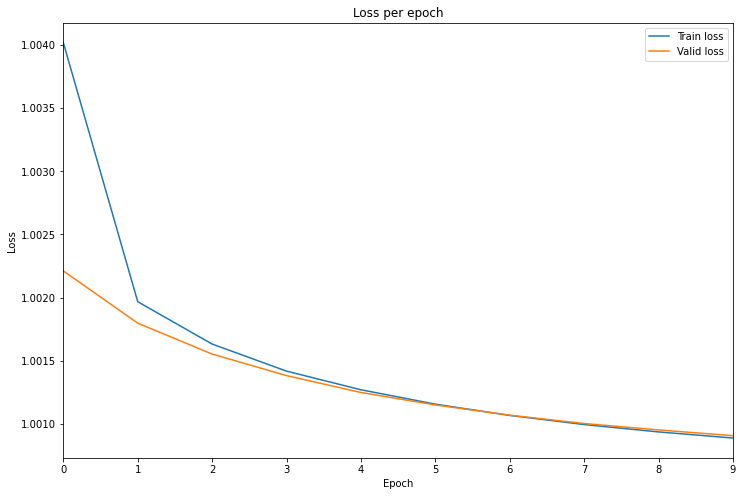

In [65]:
plt.figure(figsize=(12,8))
plt.plot(train_hist.history['loss'], label='Train loss')
plt.plot(train_hist.history['val_loss'], label='Valid loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

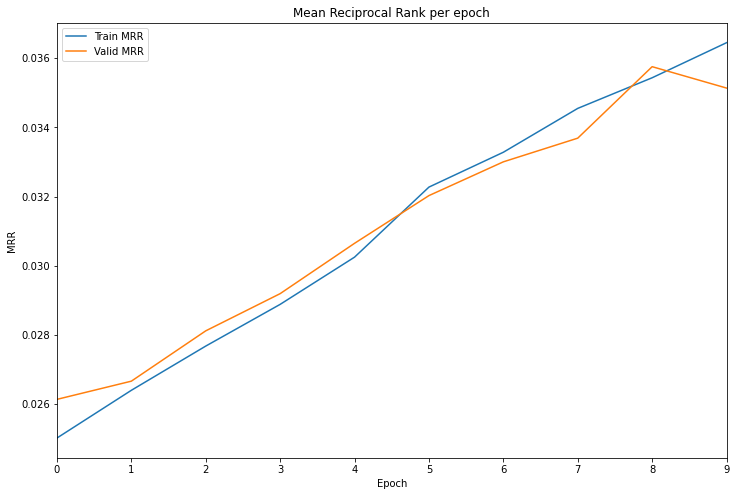

In [64]:
plt.figure(figsize=(12,8))
plt.plot(train_hist.history['mrr'], label='Train MRR')
plt.plot(train_hist.history['val_mrr'], label='Valid MRR')
plt.title('Mean Reciprocal Rank per epoch')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

# Evaluation

In [30]:
t_desc_word_ids, t_desc_input_mask, t_desc_segment_ids, t_sc_word_ids, t_sc_input_mask, t_sc_segment_ids = \
                                    generate_inputs(scope='test', n_splits=1)[:-1]
test_batch_size = 50
test_samples = len(t_desc_word_ids)
test_steps_per_epoch = test_samples // test_batch_size
test_data = tf.data.Dataset.from_tensor_slices(((t_desc_word_ids, 
                                                  t_desc_input_mask, 
                                                  t_desc_segment_ids, 
                                                  t_sc_word_ids), 
                                                 np.ones((len(t_desc_word_ids),1))))\
                            .shuffle(len(t_desc_word_ids), reshuffle_each_iteration=True)\
                            .batch(test_batch_size, drop_remainder=True)\
                            .repeat()

write_hdf5_data(t_sc_word_ids, 't_sc_word_ids')
write_hdf5_data(t_desc_word_ids, 't_desc_word_ids')
write_hdf5_data(t_desc_input_mask, 't_desc_input_mask')

15328

In [32]:
train_model.compile(loss=cos_loss, optimizer=optimizer, metrics=[mrr, frank, relevantat1, relevantat5, relevantat10])

In [ ]:
eval_res = train_model.evaluate(test_data, steps=test_steps_per_epoch)

In [107]:
print(np.round(eval_res,2))

[0.11 0.42 7.46 0.25 0.61 0.77]


In [35]:
def get_top_related_functions(desc, sc_list, desc_embedding_model, code_embedding_model): 
    desc_preprocessed = cleaning(desc)
    desc_input = generate_desc_input([desc_preprocessed], desc_max_seq_length)
    desc_vec = desc_embedding_model.predict(desc_input)
    
    sc_t_fname_ids, sc_t_api_ids, sc_t_tok_ids = generate_sc_input(sc_list,
                                                   sc_max_fname_length,
                                                   sc_max_api_length,
                                                   sc_max_seq_length,
                                                   sc_max_vocab_size,
                                                   use_vocab=sc_vocab)[1:]
    sc_vec = code_embedding_model.predict((np.array(sc_t_fname_ids), np.array(sc_t_api_ids), np.array(sc_t_tok_ids)))
    norm_desc = tf.norm(desc_vec, axis=-1, keepdims=True) + 1e-10
    norm_sc   = tf.norm(sc_vec, axis=-1, keepdims=True)   + 1e-10
    cos_similarity = tf.matmul(desc_vec/norm_desc,
                                sc_vec/norm_sc,
                                transpose_a=False,
                                transpose_b=True)
    top_indexes = np.argsort(-cos_similarity)[0]
    return top_indexes, sc_list[top_indexes], cos_similarity.numpy()[0,top_indexes]

In [59]:
b_inp, dummy = list(valid_data.take(1).as_numpy_iterator())[0]

In [60]:
cs_res = train_model.predict(b_inp, batch_size=valid_batch_size)

In [54]:
chosen_ind = 35
n_samples = 50
rand_inds = np.append([chosen_ind], np.random.randint(0, len(test_df), size=n_samples))
desc = test_df.docstring[chosen_ind]
sc_list = test_df.code[rand_inds].values

print("Given requirement:\n", test_df.docstring[chosen_ind],'\n')
print("Expected method: ", chosen_ind, "\n", test_df.code[chosen_ind],'\n')

top_k = 10
top_w_sim = get_top_related_functions(desc, sc_list, desc_embedding_model, code_embedding_model)
print(f"Position of ground-truth method in extracted set is {list(top_w_sim[0]).index(chosen_ind)}\n")
print("Predicted methods:")
for ti,jm,sim in zip(*top_w_sim[:top_k]):
    print(ti,':',sim)
    print(jm)
    print('-'*75)

Given requirement:
 Returns the number of elements in the specified iterable that equal the specified object. This
implementation avoids a full iteration when the iterable is a {@link Multiset} or {@link Set}.

<p><b>Java 8 users:</b> In most cases, the {@code Stream} equivalent of this method is {@code
stream.filter(element::equals).count()}. If {@code element} might be null, use {@code
stream.filter(Predicate.isEqual(element)).count()} instead.

@see java.util.Collections#frequency(Collection, Object) Collections.frequency(Collection,
Object) 

Expected method:  35 
 public static int frequency(Iterable<?> iterable, @NullableDecl Object element) {
    if ((iterable instanceof Multiset)) {
      return ((Multiset<?>) iterable).count(element);
    } else if ((iterable instanceof Set)) {
      return ((Set<?>) iterable).contains(element) ? 1 : 0;
    }
    return Iterators.frequency(iterable.iterator(), element);
  } 

Position of ground-truth method in extracted set is 3

Predicted met

In [179]:
top_indexes = np.argsort(-similarity_vec)[0]

In [183]:
similarity_vec.numpy()

array([[-0.63807964, -0.40510288, -0.827459  , -0.37250376,  0.3356256 ,
         0.45676202,  0.01025837, -0.06573281, -0.81076276,  0.3520301 ]],
      dtype=float32)

In [185]:
sc_list[top_indexes]

5    @CanIgnoreReturnValue\n  public long copyTo(Ch...
9    public boolean isEmpty() throws IOException {\...
4    @Beta\n  public long length() throws IOExcepti...
6    public String read() throws IOException {\n   ...
7    @NullableDecl\n  public String readFirstLine()...
3    public BufferedReader openBufferedStream() thr...
1    @Override\n  protected final char[] escape(int...
0    @Override\n  public final String escape(String...
8    public ImmutableList<String> readLines() throw...
2    @Override\n  protected final int nextEscapeInd...
Name: code, dtype: object

In [128]:
def evaluate_cos_similarity(desc_text, sc_text):
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_desc_input([desc_text], desc_max_seq_length)
    sc_ids = generate_sc_input([sc_text], model, sc_max_seq_length)
    
    res = sim_model.predict((desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids), batch_size=batch_size)

    return res

def evaluate_cos_similarities(desc_texts, sc_texts):
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_desc_input(desc_texts, desc_max_seq_length)
    sc_ids = generate_sc_input(sc_texts, model, sc_max_seq_length)
    
    res = sim_model.predict((desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids), batch_size=batch_size)

    return res

In [186]:
rand_sim_ind = np.random.randint(0, len(train_df))
rand_dif_ind = np.random.randint(0, len(train_df))
print(f"Doc 1: {train_df.docstring[rand_sim_ind]}\n")
print(f"Doc 2: {train_df.docstring[rand_dif_ind]}\n")
sim_matr = evaluate_cos_similarities(train_df.iloc[[rand_sim_ind, rand_dif_ind]].docstring, 
                                     train_df.iloc[[rand_sim_ind, rand_dif_ind]].code_tokens)
print(f"Similaity matrics:\n{sim_matr}")
print(sim_matr >= np.diag(sim_matr))

Doc 1: placeholder  dynamic  @param dynamic

Doc 2: lists annotated datasets for a dataset. pagination is supported. <p>sample code: <pre><code> try (datalabelingserviceclient datalabelingserviceclient = datalabelingserviceclient.create()) { string formattedparent = datalabelingserviceclient.formatdatasetname("[project]", "[dataset]"); string filter = ""; for (annotateddataset element : datalabelingserviceclient.listannotateddatasets(formattedparent, filter).iterateall()) { // dothingswith(element); } } </code></pre> @param parent required. name of the dataset to list annotated datasets, format: projects/{project_id}/datasets/{dataset_id} @param filter optional. filter is not supported at this moment. @throws com.google.api.gax.rpc.apiexception if the remote call fails

Similaity matrics:
[[0.9676776  0.9681637 ]
 [0.9759587  0.97649354]]
[[ True False]
 [ True  True]]


In [208]:
np.greater_equal(sim_matr, np.reshape(np.repeat(np.diag(sim_matr), 2), (2,2)))

array([[ True,  True],
       [False,  True]])